# Analysis

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import coint, grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR
import plotly.graph_objs as go
import plotly.express as px

warnings.filterwarnings("ignore")

# Exploration

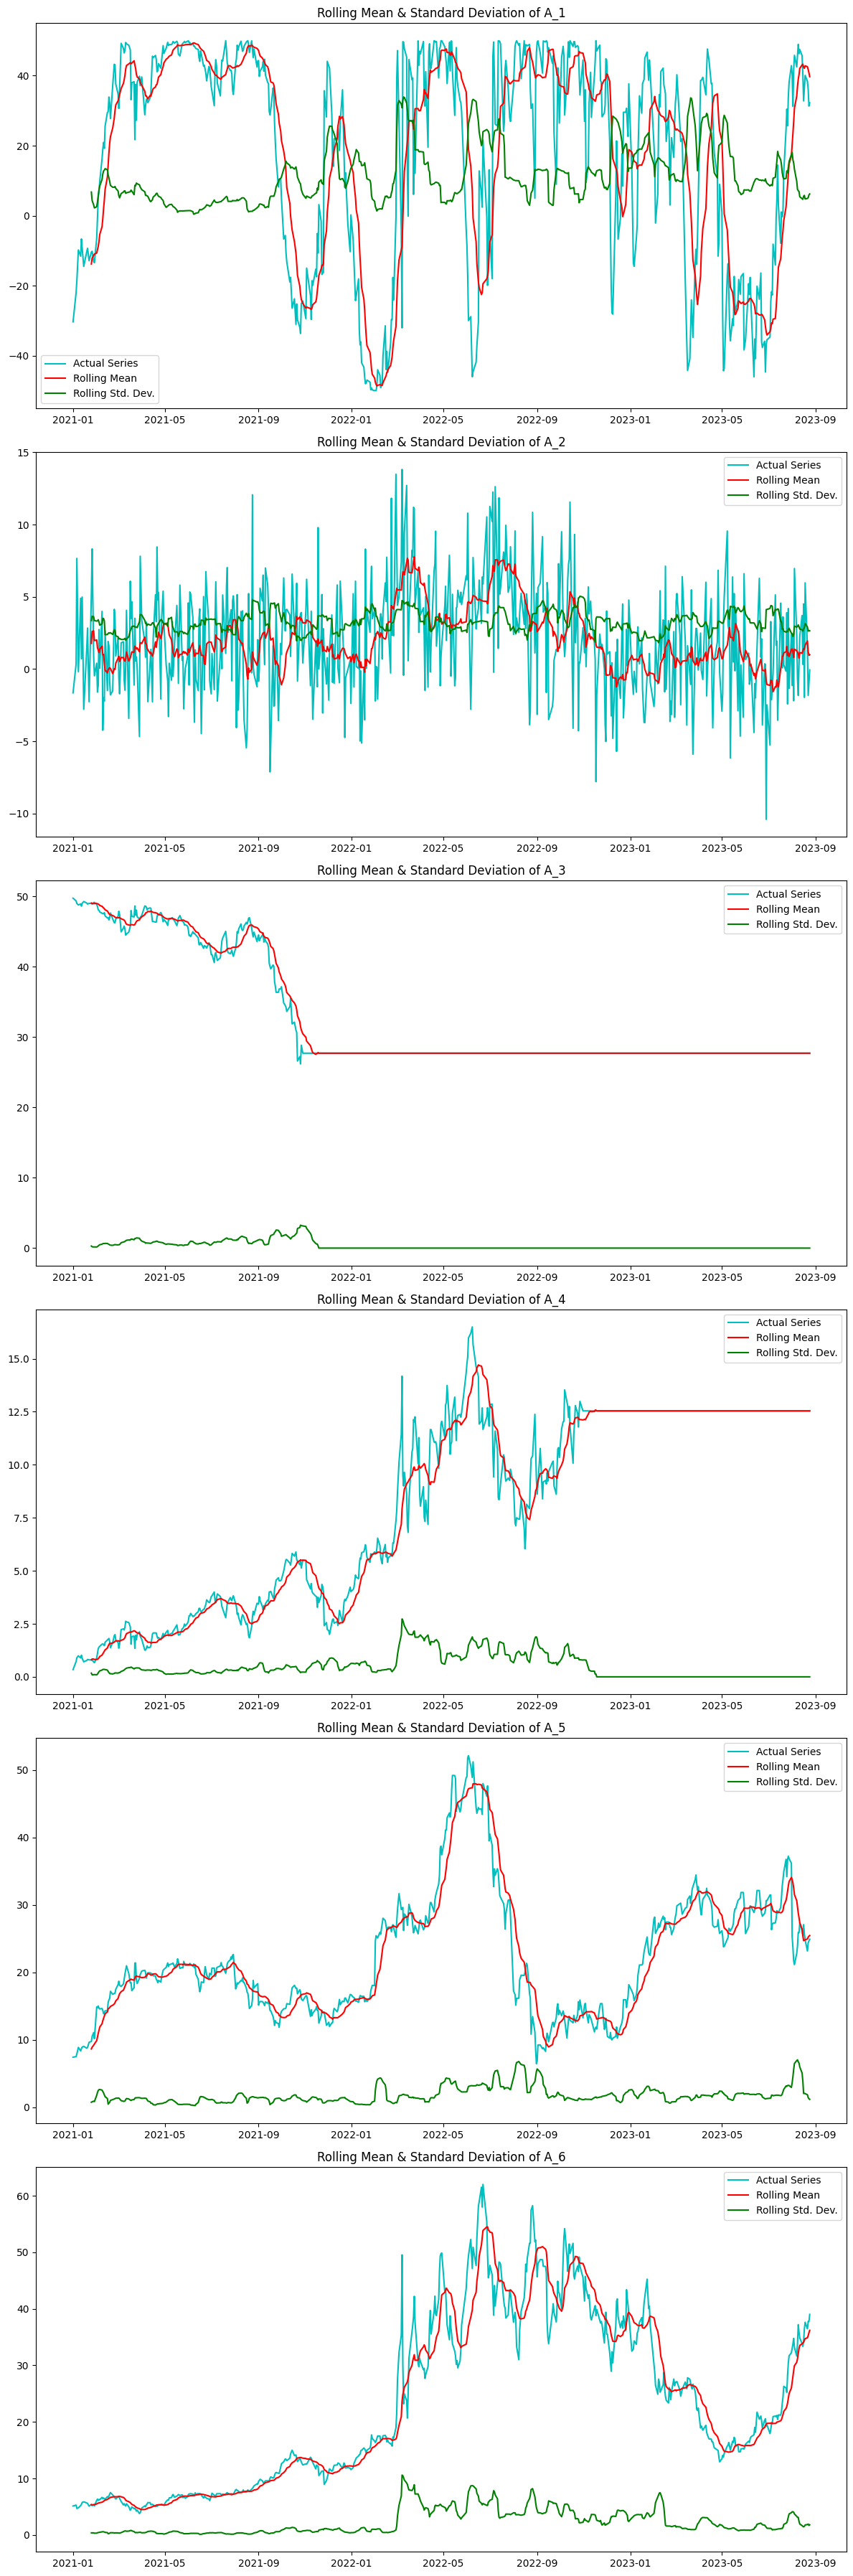

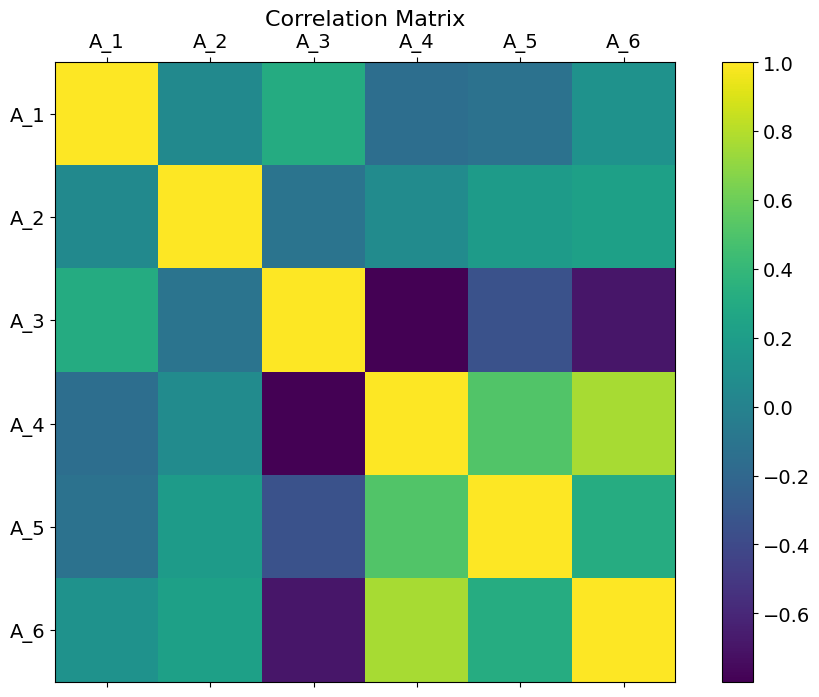

In [2]:
def get_data():
    df = pd.read_csv("Test Data Set.csv",index_col=0)
    df['Dates'] = pd.to_datetime(df['Dates'],dayfirst=True)
    df.set_index("Dates",inplace=True)
    df = df.dropna(how="any")
    return df
df = get_data()

def rolling_plots(df, cols=df.columns):
    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(12, 6 * len(cols)))

    for i, col in enumerate(cols):
            rolmean = df[col].rolling(window=12).mean()
            rolstd = df[col].rolling(window=12).std()
            
            axes[i].plot(df[col], color='c', label='Actual Series')
            axes[i].plot(rolmean, color='red', label='Rolling Mean')
            axes[i].plot(rolstd, color='green', label='Rolling Std. Dev.')
            axes[i].set_title(f'Rolling Mean & Standard Deviation of {col}')
            axes[i].legend()

    plt.tight_layout()
    plt.show()


def corr_plot(df):
    f = plt.figure(figsize=(12,8))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)



fig = px.line(df,x=df.index,y=df.columns)
fig.show()
rolling_plots(df)
corr_plot(df)

In [183]:
def plots(df):
    # Calculate rolling standard deviation for all columns

    normalized_df=(df-df.mean())/df.std()
    
    # Create a figure with subplots for each column
    fig = px.line(normalized_df, x=normalized_df.index, y=normalized_df.columns, title=f'Plots')
    
    # Customize the figure layout
    fig.update_layout(xaxis_title='Date', yaxis_title='Value')
    
    # Show the plot
    fig.show()

plots(df)



def plot_rolling_std(df, window_size=30):
    # Calculate rolling standard deviation for all columns
    rolling_std = df.rolling(window=window_size).std()

    normalized_df=(rolling_std-rolling_std.mean())/rolling_std.std()
    
    # Create a figure with subplots for each column
    fig = px.line(normalized_df, x=normalized_df.index, y=normalized_df.columns, title=f'Rolling Standard Deviation (Window Size: {window_size})')
    
    # Customize the figure layout
    fig.update_layout(xaxis_title='Date', yaxis_title='Standard Deviation')
    
    # Show the plot
    fig.show()

plot_rolling_std(df,window_size=30)

Upon initial examination, we observe a dataset comprising six variables denoted as A_1 to A_6. None of these variables exhibit a consistent behavior over time; instead, they display varying means and fluctuations. Furthermore, it is evident that A_3 and A_4 stabilize with constant values following November 2021 and November 2022, respectively. Notably, a noticeable correlation exists between A_4 and A_6. It's worth mentioning that rows containing missing values were omitted before conducting the analysis.

It's important to note that while there appears to be a negative correlation between A_3 and A_4, this observation might be misleading due to the prolonged period of constant values in both variables. Additionally, A_3 and A_6 exhibit a similar trend. Conversely, a robust positive correlation is evident between A_4 and A_6, suggesting a potential relationship between these two variables. In contrast, the remaining variables demonstrate relatively weak correlations, making a thorough assessment challenging without further analysis.

# Answers

A. Please look at relationships between A_1 and A_2 as well as A_1 and A_3. Please do this for date range between 1st of Jan and 30th of Sep for a given calendar year. Are there any periods within this time frame when the relationships change significantly?

We will begin by creating functions to facilitate our data analysis. The dataset is then divided into three separate dataframes, each corresponding to a different year. To explore the relationships between the variables, we will focus on two combinations: A_1 with A_2, and A_1 with A_3, within the main function named `part_a`.

Our approach involves conducting relationship tests on a rolling basis to assess how the dynamics change over time. This approach offers a more detailed insight into the changes compared to metrics that consider the entire dataset in one go. Our goal is to pinpoint the exact dates when these relationships change.

We begin by calculating the rolling covariance, a measure of the direction of the relationship between two variables. Positive and high covariance values indicate that the variables are moving in the same direction, with the magnitude representing the strength of the relationship. Conversely, negative covariance suggests that one variable is moving in the opposite direction of the other.

Next, we compute and visualize the rolling cointegration between the variables. This involves performing a hypothesis test with the null hypothesis stating that there is no cointegration between the variables. The test, known as the Engle-Granger test, returns a p-value. If this p-value is below our chosen threshold (5%), we can reject the null hypothesis, indicating the presence of statistically significant cointegration.

We also perform a Granger causality test to assess causality between the variables. This test is another hypothesis test that determines if one variable can be used to forecast another. It assumes that a cause precedes its effect and uses past data in one variable to predict the other. In this context, we examine whether the test yields a p-value below our threshold, indicating the number of lags, if any, required to predict the variable with statistical significance.

The rolling window size is set to 30 to capture intramonth trends effectively.

In [3]:
# Splits the DataFrame by year and returns a list of DataFrames for each year.
def year_split(df):
    yrs = df.index.year.unique()
    dfs = []

    for yr in yrs:
        temp = df[df.index.year == yr]
        end_date = f"{list(temp.index.year)[0]}-09-30"
        filtered_yr = temp[temp.index <= end_date]
        dfs.append(filtered_yr)

    return dfs

# Plots the rolling covariance between two columns in a DataFrame.
def rolling_covariance_plot(df, col1, col2, window):
    rolling_cov = df[col1].rolling(window=window).cov(df[col2])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=rolling_cov, mode='lines', name='Rolling Covariance', line=dict(color='blue')))
    
    fig.update_layout(title=f'Rolling Covariance between {col1} and {col2}',
                      xaxis_title='Date',
                      yaxis_title='Rolling Covariance',
                      showlegend=True)
    
    fig.show()

# Performs rolling cointegration analysis between two columns in a DataFrame.
def rolling_cointegration_analysis(yr, col1, col2, window_size=30, significance_threshold=0.05):
    cointegration_results = pd.DataFrame(columns=['Start Date', 'End Date', 'P-value'])

    p_values = []
    start_dates = []
    end_dates = []

    for i in range(len(yr) - window_size + 1):
        window_data = yr.iloc[i:i+window_size] 
        result = coint(window_data[col1], window_data[col2])

        cointegration_results = cointegration_results.append({
            'Start Date': window_data.index[0],
            'End Date': window_data.index[-1],
            'P-value': result[1]
        }, ignore_index=True)

        p_values.append(result[1])
        start_dates.append(window_data.index[0])
        end_dates.append(window_data.index[-1])

    significant_results = cointegration_results[cointegration_results['P-value'] < significance_threshold]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=start_dates, y=p_values, mode='lines', name='P-value'))
    fig.add_shape(
        type='line',
        x0=min(start_dates),
        x1=max(start_dates),
        y0=significance_threshold,
        y1=significance_threshold,
        line=dict(color='red', dash='dash'),
        name=f'Significance Threshold ({significance_threshold})'
    )

    fig.update_layout(
        title=f'Rolling Cointegration Analysis ({col1} vs {col2})',
        xaxis_title='Time',
        yaxis_title='P-value',
        showlegend=True,
        grid=dict(rows=1, columns=1, pattern='independent', xaxes=['x'], yaxes=['y'], xgap=0.2, ygap=0.3),
    )

    fig.show()

# Calculates and prints Pearson and Spearman correlations between two variables in a DataFrame.
def relationship_test(df,var1,var2):
    pearsoncorr, _ = pearsonr(df[var1], df[var2])
    print(f"Pearson correlation: {round(pearsoncorr,3)}")
    spearmancorr, _ = spearmanr(df[var1], df[var2])
    print(f"Spearman correlation: {round(spearmancorr,3)}\n")

# Performs Granger causality tests between two columns in a DataFrame for different time lags.
def granger_causality_test(df, column1, column2, max_lags=20, significance_threshold=0.05):

    p_values1_to_2 = []
    p_values2_to_1 = []

    for lag in range(1, max_lags + 1):
        data = df[[column1, column2]]

        # col2 causes col1
        test_result1_to_2 = grangercausalitytests(data.diff().dropna(), maxlag=lag, verbose=False)
        p_value1_to_2 = test_result1_to_2[lag][0]['ssr_ftest'][1]
        p_values1_to_2.append(p_value1_to_2)
        
        # col1 causes col2
        data = df[[column2, column1]] 
        test_result2_to_1 = grangercausalitytests(data.diff().dropna(), maxlag=lag, verbose=False)
        p_value2_to_1 = test_result2_to_1[lag][0]['ssr_ftest'][1]
        p_values2_to_1.append(p_value2_to_1)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lags + 1), p_values1_to_2, marker='o', linestyle='-', color='b', label=f'{column2} causes {column1}')
    plt.plot(range(1, max_lags + 1), p_values2_to_1, marker='o', linestyle='-', color='r', label=f'{column1} causes {column2}')
    plt.axhline(y=significance_threshold, color='g', linestyle='--', label=f'Significance Threshold ({significance_threshold})')
    plt.title(f'Granger Causality Test: {column1} <-> {column2}')
    plt.xlabel('Number of Lags')
    plt.ylabel('p-value')
    plt.grid(True)
    plt.xticks(range(1, max_lags + 1))
    plt.legend()
    plt.show()

# Combined function to address questions for part A
def part_a(df,cols):
    col1, col2 = cols

    yrs = year_split(df)
    for yr in yrs:
        yr = yr[[col1,col2]]
        relationship_test(yr, col1, col2)
        rolling_covariance_plot(yr, col1, col2, window=30)
        rolling_cointegration_analysis(yr, col1, col2, window_size=30)
        try:
            granger_causality_test(yr, col1, col2)
        except:
            pass


Pearson correlation: 0.04
Spearman correlation: 0.037



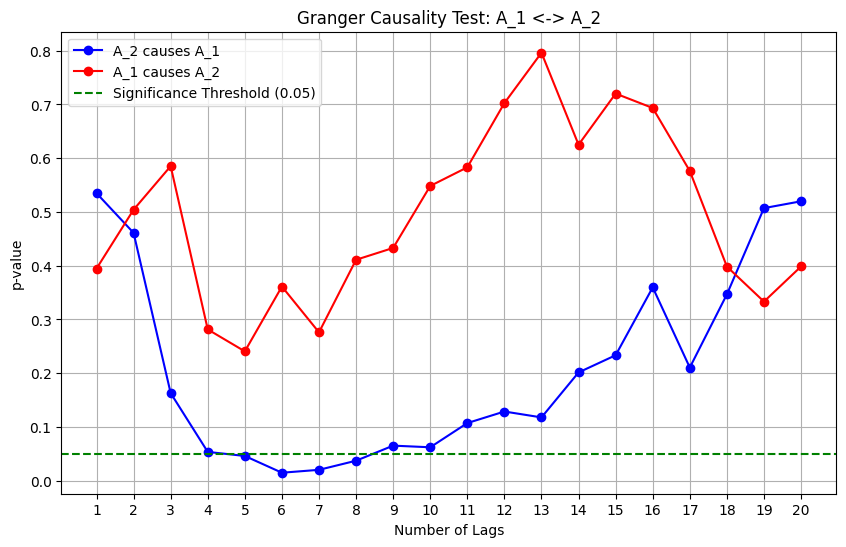

Pearson correlation: 0.104
Spearman correlation: 0.051



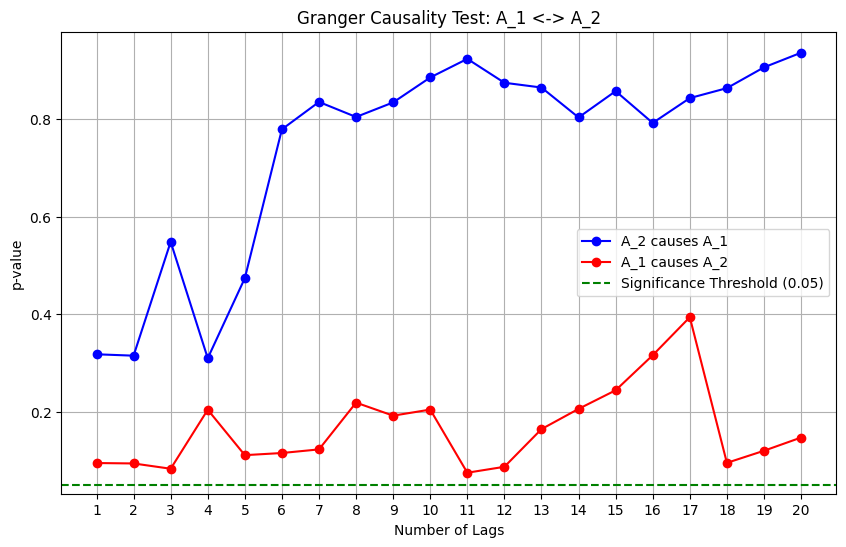

Pearson correlation: 0.097
Spearman correlation: 0.079



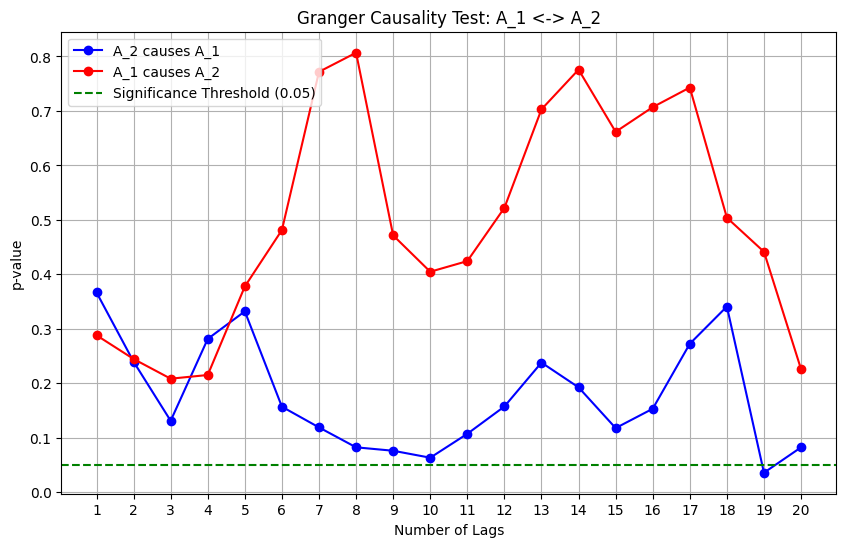

In [4]:
part_a(df,['A_1', 'A_2'])

A_1 vs. A_2 Analysis:

2021:
In 2021, the covariance analysis reveals that A_1 and A_2 initially had a negative relationship starting around mid-February, which gradually turned positive with a peak magnitude of approximately 10 by mid-March. This positive trend continued until mid-April, after which it oscillated around zero until mid-August. In late August, there was a sharp drop followed by a rapid increase in September. The cointegration analysis suggests statistically significant changes occurred around mid-March, mid-April, late April, early June, and late June. However, these changes were short-lived and didn't persist for an extended period. The Granger causality test indicates that A_2 might have a causal influence on A_1 when the lag is between 4-8.

2022:
In 2022, the covariance pattern differs significantly. It starts at the end of February, showing strong positive correlation peaking in mid-March before dropping to zero by early April. Subsequently, there are fluctuations, including negative correlations, until early July, when some positive correlation reappears. The cointegration analysis highlights a substantial change in the relationship between the end of February and early April, with short-lived spikes indicating transient changes. The Granger causality test does not provide significant evidence of one variable causing the other.

2023:
In 2023, the covariance analysis shows a large, positively correlated movement between A_1 and A_2, starting in late February and lasting until early May. This is followed by a prolonged period of negative correlation until mid-June, after which it mostly remains positive. The cointegration analysis identifies a significant change from late April to mid-May, with occasional short-lasting spikes. Interestingly, Granger's test suggests that A_2 might cause A_1 when the lag is 19, which differs from the previous years.

Summary:
Across all years, there is a consistent pattern of peak covariance in March, indicating that March is a period where A_1 and A_2 are most likely to move in the same direction. This observation is supported by the cointegration tests, which also show significant changes during the same time frame.

Pearson correlation: -0.293
Spearman correlation: -0.295



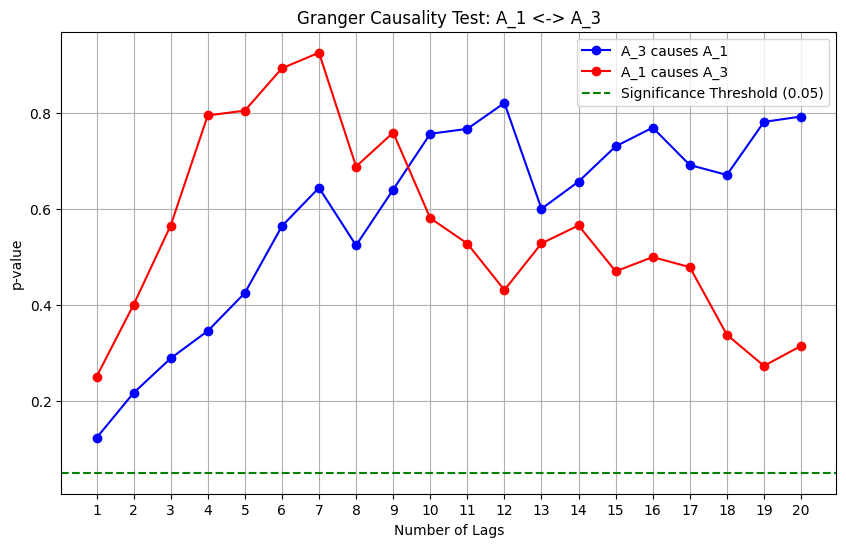

Pearson correlation: nan
Spearman correlation: nan



Pearson correlation: nan
Spearman correlation: nan



In [5]:
part_a(df,['A_1', 'A_3'])

A_1 vs. A_3 Analysis:

2021:
In 2021, the covariance analysis indicates an initially negative relationship between A_1 and A_3, suggesting they were moving in opposite directions. Over time, this relationship gradually shifted, reaching a value of zero by mid-June, and then rising to approximately 7 by mid-September. The cointegration analysis shows spikes below our threshold, increasing in frequency from the end of May. However, Granger's tests do not provide any evidence of causation between these variables.

2022 and 2023:
For both 2022 and 2023, the data for A_3 remains flat starting from November 2021. As a result, the metrics may not be relevant to our analysis during these years. This flat trend is likely because A_1 determines all movement from November 2021 onwards.

Summary:
There is evidence to suggest a significant change in the relationship between A_1 and A_3, starting from the end of May 2021 and continuing until the end of September 2021. However, for the subsequent years, the flat data for A_3 indicates that the metrics may not be informative for our analysis.

B. Please look at relationship between A_4 and A_5 as well as A_4 and A_6.

In [6]:
def part_b(df,cols):
    yr = df.copy()
    col1, col2 = cols
    yr = yr[[col1,col2]]
    relationship_test(yr, col1, col2)
    rolling_covariance_plot(yr, col1, col2, window=90)
    rolling_cointegration_analysis(yr, col1, col2, window_size=90)
    try:
        granger_causality_test(yr, col1, col2)
    except:
        pass

Pearson correlation: 0.514
Spearman correlation: 0.447



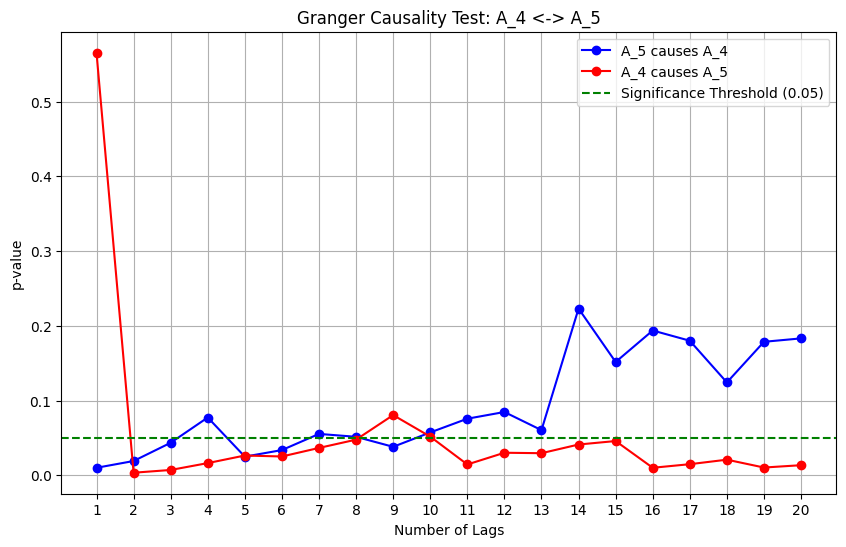

In [7]:
part_b(df,['A_4', 'A_5'])

A_4 vs. A_5 Analysis:

In this analysis, we will consider data from all three years. Notably, the correlation between A_4 and A_5 appears to be stronger compared to the relationships between A_1, A_2, and A_3. Both the Pearson and Spearman correlation coefficients are approximately 0.5, indicating a modest positive correlation.

To accommodate the larger dataset, we adjusted the rolling window size accordingly. The covariance plot shows a flat trend around 0 from June 2021 to January 2022, suggesting an independent relationship during this period. However, there is a significant increase in covariance from January 2022 to mid-June 2022, which mostly remains positive until November 2022.

It's important to note that A_4 becomes flat after November 2022, which may impact the results in subsequent periods. The cointegration analysis reveals a substantial change in the relationship between February 2022 and March 2022, coinciding with the rapid increase in covariance during that time. Granger's test provides evidence that both variables may be causing each other.

Summary:
The most significant change in the relationship between A_4 and A_5 occurred from February 2022 to March/April 2022, as indicated by both the covariance and cointegration analyses.

Pearson correlation: 0.766
Spearman correlation: 0.78



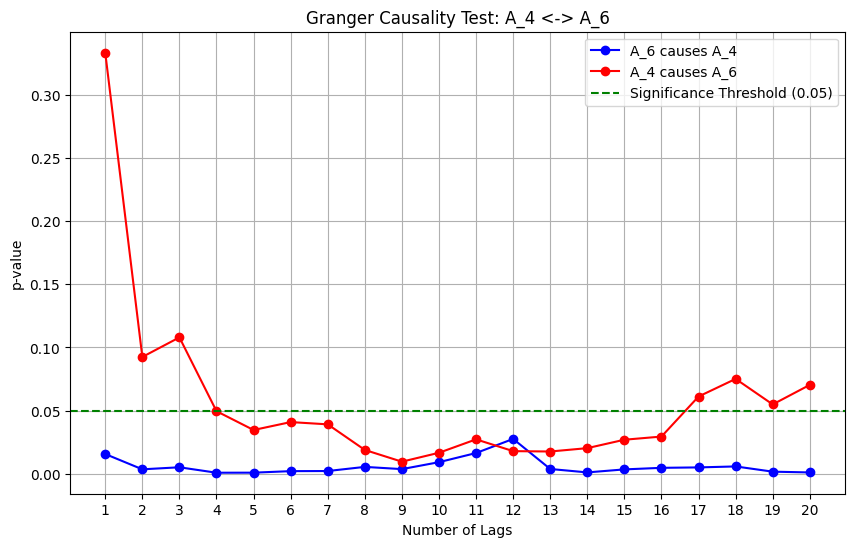

In [8]:
part_b(df,['A_4', 'A_6'])

A_4 vs. A_6 Analysis:

The covariance analysis reveals a relatively flat profile until the end of November 2021. At this point, both variables start moving in the same direction with a high magnitude, exhibiting similar patterns to the previous analysis. This positive covariance trend continues until December 2022, after which it fluctuates around 0.

The cointegration analysis indicates significant changes in the relationship between November 2021 and January 2022, with various short spikes observed in other periods. Notably, there is strong evidence of causation on both sides, with just one lag being sufficient for A_6 to cause A_4.

It's worth noting that A_4 remains flat after November 2022, which may impact the interpretation of some results.

Summary:
The most substantial change in the relationship occurred from November 2021 to January 2022 for cointegration, but primarily from February 2022 to September 2022 considering the covariance.

C. If there is anything at all that you can deduce from the data set, please highlight it.

In our analysis, several intriguing patterns and deductions emerge from the dataset. First and foremost, it becomes evident that variables A_3 and A_4 likely represent some form of derivative contracts, given that their values consistently conclude in November. This temporal pattern strongly implies a connection to December or calendar contracts within the data.

Furthermore, a compelling correlation emerges between A_4 and A_6. This correlation hints at the possibility that A_6 might mirror the price movements of the underlying product represented by A_4. In other words, A_4 may either influence or serve as a key indicator of changes in A_6's value.

Expanding on this notion, A_5 also exhibits a noteworthy correlation with A_4, and there is substantial evidence to suggest that both A_4 and A_5 influence each other. This relationship implies that A_5 could be associated with factors impacting A_4, possibly related to volatility or forward margin data.

However, the analysis reveals weaker evidence regarding the relationships involving A_2, A_3, and A_1. This suggests that these variables may not significantly influence or be influenced by one another within the dataset.

In summary, these findings provide valuable insights into the potential roles and connections of the variables in the dataset, shedding light on the nature of A_3, A_4, A_5, A_6, and their interdependencies, while indicating a lesser degree of interaction among A_2, A_3, and A_1.


p-value = 0.01466413352669322, null hypothesis rejected
A_1 is stationary

p-value = 0.07329728454972315, null hypothesis not rejected
A_2 is non-stationary

p-value = 0.27644846283851876, null hypothesis not rejected
A_5 is non-stationary

p-value = 0.6625483265240284, null hypothesis not rejected
A_6 is non-stationary

p-value = 4.843746772166379e-27, null hypothesis rejected
A_1 is stationary

p-value = 2.02986878530899e-11, null hypothesis rejected
A_2 is stationary

p-value = 0.0, null hypothesis rejected
A_5 is stationary

p-value = 7.491320588173739e-12, null hypothesis rejected
A_6 is stationary
30

For variable: A_1
mape = 8.492545256484513
mpe  = 1.0773470184415213
rmse = 65.34617076639483


For variable: A_2
mape = 3.2485354065016
mpe  = -2.225360770215329
rmse = 3.493444832429939


For variable: A_5
mape = 0.1852941365728554
mpe  = 0.12751631840548527
rmse = 5.5736100999713


For variable: A_6
mape = 0.3542157428832032
mpe  = -0.34918105637383123
rmse = 12.939273840265473


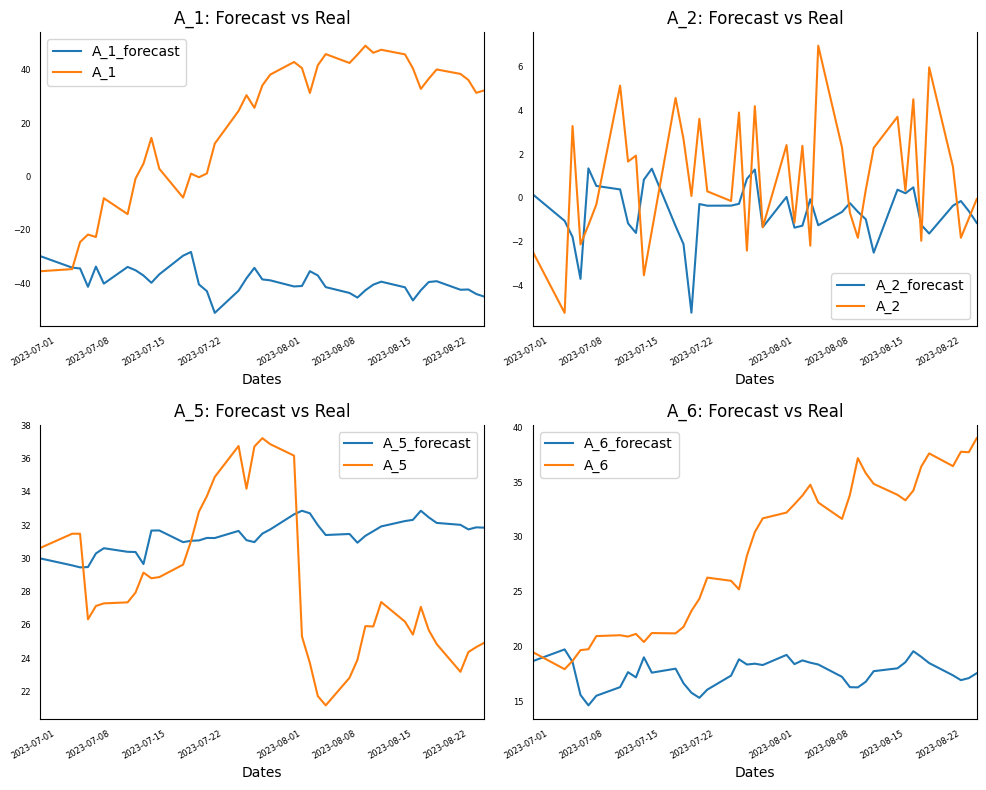

In [176]:
# EXTRA
# Sample VAR model for A_1 and A_2
df = get_data()
data = df[["A_1", "A_2","A_5", "A_6"]]
n = 40
train_data, test_data = data[:-n], data[-n:]

def adf_test(df):
    for col in df.columns:
        sig_level = 0.05
        adf = adfuller(df[col].values, autolag='AIC')
        p_val = adf[1]
        if p_val <= sig_level:
            print(f"\np-value = {p_val}, null hypothesis rejected")
            print(f"{col} is stationary")
        else:
            print(f"\np-value = {p_val}, null hypothesis not rejected")
            print(f"{col} is non-stationary")

adf_test(train_data)
train_data_diff = train_data.diff().dropna()
adf_test(train_data_diff)

# Step 6: Select order to minimise AIC
model = VAR(train_data_diff)
lag_order_aic = 30

model_fit = model.fit(lag_order_aic)
# Step 8: Forecast
lag_order = model_fit.k_ar
print(lag_order)
forecast_input = train_data_diff
fc = model_fit.forecast(y=forecast_input.values, steps=n)
data_forecast = pd.DataFrame(fc,index=test_data.index[-n:], columns=data.columns)
                             
# Step 9: Reverse the differencing
data_fc = data_forecast.copy()
columns = train_data.columns
for col in columns:
    # Roll back difference
    data_fc[col] = train_data[col].iloc[-1] + data_fc[col].cumsum()
    
data_fc.columns = [col+"_forecast" for col in columns]

# Step 10: Plots
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=100, figsize=(10,8))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    data_fc[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_data[col][-n:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Real")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

# Step 11: Metrics
for i,j in zip(data.columns,data_fc.columns):
    if i in j:
        mape = np.mean(np.abs(data_fc[j] - test_data[i])/np.abs(test_data[i]))
        mpe = np.mean((data_fc[j] - test_data[i])/test_data[i])
        rmse = np.mean((data_fc[j] - test_data[i])**2)**0.5
        print(f"\nFor variable: {i}")
        print(f"mape = {mape}\nmpe  = {mpe}\nrmse = {rmse}\n")

In [156]:
# df = get_data()
# (df["A_6"]-df["A_5"]).plot()
# plt.axhline((df["A_6"] - df["A_5"]).mean(), color='red', linestyle='--')
# plt.show()


df = df.diff().dropna()
score, pvalue, _ = coint(df["A_6"],df["A_5"])
print(pvalue)




2.1206750918026444e-19


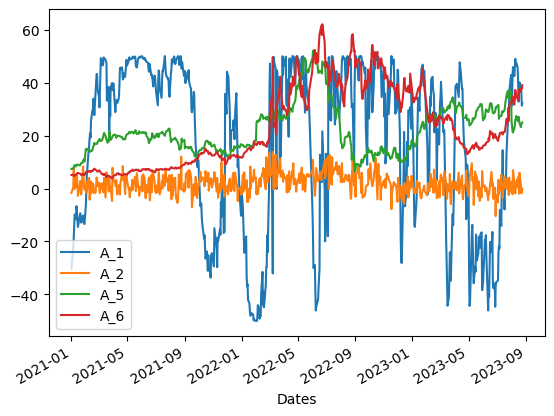

In [16]:
df = get_data()
df = df[["A_1","A_2","A_5","A_6"]]
df.plot()
plt.show()

In [105]:
df = get_data()
df = df[["A_1","A_2","A_5","A_6"]]
# df = df.diff().dropna()

# adf_test(df)

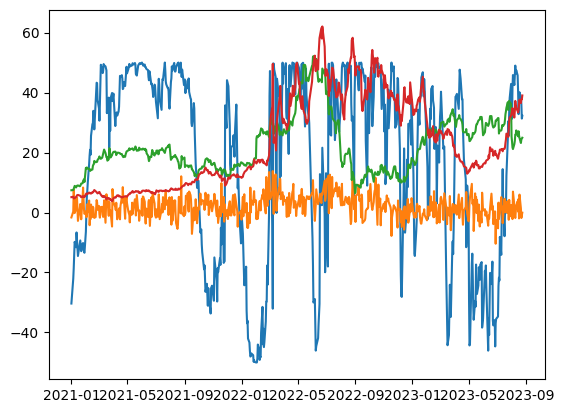

In [106]:
plt.plot(df)
plt.show()

In [122]:
df = get_data()
rolling_cointegration_analysis(df[["A_1","A_2"]],"A_1","A_2",window_size=50)
rolling_cointegration_analysis(df[["A_5","A_6"]],"A_5","A_6",window_size=50)
# rolling_cointegration_analysis(df[["A_5","A_6"]],"A_5","A_6")


In [123]:
# granger_causality_test(df,"A_1","A_2")
# granger_causality_test(df,"A_1","A_5")
# granger_causality_test(df,"A_2","A_5")


# granger_causality_test(df,"A_1","A_6")
# granger_causality_test(df,"A_2","A_6")
# granger_causality_test(df,"A_5","A_6")




From this, it can be seen that A_1, A_2 and A_5 all cause A_6 at different lags

A_1 causing A_6: 15-20 lags

A_2 causing A_6: 10-20 lags

A_5 causing A_6: 5-6 lags

A_1 and A_5 causing each other at 3-4 lags
